## Import Libraries

In [153]:
import tensorflow as tf
import os
from glob import glob

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D, UpSampling2D,Add,Multiply
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import Xception

# Path to Augmented Dataset

In [3]:
path1 = "/kaggle/input/augglaucomags/aug/img/*"
path2 = "/kaggle/input/augglaucomags/aug/OD/*"
path3 = "/kaggle/input/augglaucomags/aug/OC/*"

# Enable GPU

In [5]:
tf.test.is_gpu_available()

True

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Storing image paths in lists

In [7]:
train_files = glob(path1)
od_files = glob(path2)
oc_files = glob(path3)

train_files.sort()
od_files.sort()
oc_files.sort()

print(len(train_files))
print(len(od_files))
print(len(oc_files))

707
707
707


# Xception as encoder

In [8]:
input_shape = (256,256,3)
inputs = Input(input_shape)
encoder = Xception(include_top=False, weights="imagenet", input_tensor=inputs)

83683744/83683744 [==============================] - 0s 0us/step


In [9]:
encoder.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

# Xception U-Net

In [292]:

def conv_blockX(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_blockX(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_blockX(x, num_filters)
    return x

def Xunet(input_shape):
    """ Input """
#     inputs = Input(input_shape)
    
    s1 = encoder.get_layer("input_1").output          

    s2 = encoder.get_layer("block1_conv1_act").output  
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)        

    s3 = encoder.get_layer("block3_sepconv2_act").output 
    s3 = ZeroPadding2D(( (1, 0), (1, 0) ))(s3)         

    """Bridge"""
    b1 = encoder.get_layer("block4_sepconv2_act").output      
#     b1 = ZeroPadding2D(( (1, 0), (1, 0) ))(b1)          

                    

    """ Decoder """
    
#     d1 = decoder_block(b1, s4, 512)                    
    d2 = decoder_blockX(b1, s3, 256)                    
    d3 = decoder_blockX(d2, s2, 128)                     
    d4 = decoder_blockX(d3, s1, 64)                     
   
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="XUNet")
    return model

# Residual-Xception U-Net

In [364]:

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def conv_blockX(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_blockX(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
#     x = conv_blockX(x, num_filters)
    return x

def ResidualX(input_shape):
    """ Input """
#     inputs = Input(input_shape)
    
    s1 = encoder.get_layer("input_1").output          

    s2 = encoder.get_layer("block1_conv1_act").output  
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)        

    s3 = encoder.get_layer("block3_sepconv2_act").output 
    s3 = ZeroPadding2D(( (1, 0), (1, 0) ))(s3)   
    

    """Bridge"""
    b1 = encoder.get_layer("block4_sepconv2_act").output      
#     b1 = ZeroPadding2D(( (1, 0), (1, 0) ))(b1)  


                    

    """ Decoder """
    
#     d1 = decoder_block(b1, s4, 512)                    
    d2 = decoder_blockX(b1, s3, 256)                    
    d3 = decoder_blockX(d2, s2, 128)                     
    d4 = decoder_blockX(d3, s1, 64)                     
   
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="XUNet")
    return model

In [365]:
# input_shape = (256,256, 3)
# modelX = Xunet(input_shape)
# modelX.summary()

In [366]:
input_shape = (256,256, 3)
modelRX = ResidualX(input_shape)
modelRX.summary()

Model: "XUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [225]:
# input_shape = (256,256, 3)
# model1 = X(input_shape)
# model1.summary()

# Calculating Metrics 

In [367]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training Model with Data

In [423]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
# from model import build_resunet
# from metrics import dice_loss, dice_coef, iou

""" Global Parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "/kaggle/input/augglaucomags/aug/img/", "*.png")))
    print(len(images))
    masks = sorted(glob(os.path.join(path, "/kaggle/input/augglaucomags/aug/OD/", "*.png")))
    print(len(masks))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=0.1, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size= 0.1, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-4
    num_epochs = 20
    model_path = os.path.join("model-unet-OD.h5")
#     csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = "/kaggle/working/aug/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
    model = ResidualX((H,W,3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
#         CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

707
707
Train: 508 - 508
Valid: 142 - 142
Test: 57 - 57
Epoch 1/20
254/254 [==============================] - ETA: 0s - loss: 0.2779 - dice_coef: 0.7221 - iou: 0.5905 - recall_22: 0.8335 - precision_22: 0.6814
Epoch 1: val_loss improved from inf to 0.99006, saving model to model-unet-OD.h5
254/254 [==============================] - 105s 388ms/step - loss: 0.2779 - dice_coef: 0.7221 - iou: 0.5905 - recall_22: 0.8335 - precision_22: 0.6814 - val_loss: 0.9901 - val_dice_coef: 0.0099 - val_iou: 0.0050 - val_recall_22: 0.0000e+00 - val_precision_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
254/254 [==============================] - ETA: 0s - loss: 0.1211 - dice_coef: 0.8789 - iou: 0.7889 - recall_22: 0.8555 - precision_22: 0.9440
Epoch 2: val_loss improved from 0.99006 to 0.80822, saving model to model-unet-OD.h5
254/254 [==============================] - 99s 391ms/step - loss: 0.1211 - dice_coef: 0.8789 - iou: 0.7889 - recall_22: 0.8555 - precision_22: 0.9440 - val_loss: 0.8082 - val_dice_co

In [424]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
# from metrics import dice_loss, dice_coef, iou
# from train import load_data, create_dir

H = 256
W = 256

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (H, W))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (H, W))
    ori_x = x
    x = x/np.max(x)
    x = x.astype(np.int32)
    return ori_x, x

def save_result(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255.0

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)    ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0 ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


np.random.seed(42)
tf.random.set_seed(42)

    
create_dir("results")

with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model("model-unet-OD.h5")

  
dataset_path = "/kaggle/working/aug/"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

   
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
      
        name = x.split("/")[-1]

      
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

      
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

       
        save_image_path = f"results/{name}"
        save_result(ori_x, ori_y, y_pred, save_image_path)

        y = y.flatten()
        y_pred = y_pred.flatten()

       
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

 
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
# df.to_csv("files/score.csv")

707
707


  0%|          | 0/57 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 1/57 [00:01<01:38,  1.77s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 2/57 [00:02<00:48,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 3/57 [00:02<00:30,  1.76it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 4/57 [00:02<00:23,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 5/57 [00:02<00:19,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 6/57 [00:02<00:15,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 7/57 [00:03<00:13,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 8/57 [00:03<00:13,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 9/57 [00:03<00:11,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 10/57 [00:03<00:10,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 11/57 [00:04<00:10,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 12/57 [00:04<00:11,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 13/57 [00:04<00:09,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 14/57 [00:04<00:09,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 15/57 [00:04<00:08,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 16/57 [00:05<00:08,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 17/57 [00:05<00:07,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 18/57 [00:05<00:08,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 19/57 [00:05<00:07,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 20/57 [00:05<00:08,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 21/57 [00:06<00:08,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 22/57 [00:06<00:07,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 23/57 [00:06<00:07,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 24/57 [00:06<00:07,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 25/57 [00:07<00:07,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 26/57 [00:07<00:07,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 27/57 [00:07<00:07,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 28/57 [00:07<00:06,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 29/57 [00:07<00:06,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 30/57 [00:08<00:05,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 31/57 [00:08<00:05,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 32/57 [00:08<00:04,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 33/57 [00:08<00:04,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 34/57 [00:08<00:04,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 35/57 [00:09<00:04,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 36/57 [00:09<00:04,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 37/57 [00:09<00:04,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 38/57 [00:09<00:03,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 39/57 [00:09<00:03,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 40/57 [00:10<00:03,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 41/57 [00:10<00:03,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 42/57 [00:10<00:03,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 43/57 [00:10<00:03,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 44/57 [00:11<00:03,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 45/57 [00:11<00:03,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 46/57 [00:11<00:02,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 47/57 [00:11<00:02,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 48/57 [00:12<00:01,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 49/57 [00:12<00:01,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 50/57 [00:12<00:01,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 51/57 [00:12<00:01,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 52/57 [00:12<00:00,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 53/57 [00:13<00:00,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 54/57 [00:13<00:00,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 55/57 [00:13<00:00,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 56/57 [00:13<00:00,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 57/57 [00:13<00:00,  4.09it/s]

Accuracy: 0.99497
F1: 0.92155
Jaccard: 0.86070
Recall: 0.99118
Precision: 0.86829


# Displaying the Results

In [395]:
from glob import glob
a = glob("/kaggle/working/results/*")
print(len(a))

57


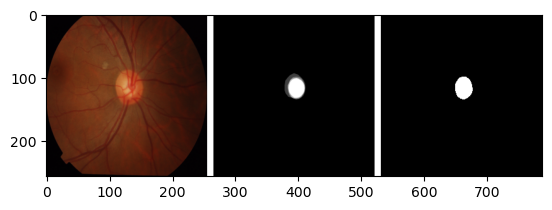

In [410]:
from PIL import Image
import matplotlib.pyplot as plt
a1 = Image.open(a[28])
plt.imshow(a1)
plt.show()

# Displaying graphs

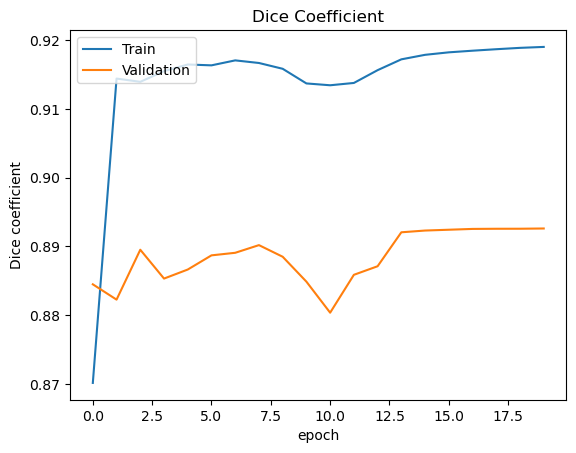

In [411]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

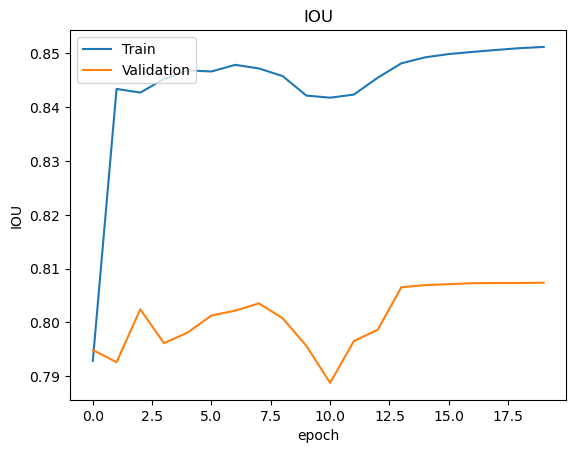

In [412]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IOU')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')